In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import yaml
import time
import os

from scipy.stats import linregress
from sklearn.metrics import mean_squared_error


In [2]:
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [3]:
ulp_in_dir = '../../MBC/filtering_and_correction_analysis/merged_data'
deep_in_dir = '../../MBC/deepWGS_filtering_and_correction_analysis/merged_data'

uncorrected_stats_path = 'files/exclusion_filtered.uncorrected.tsv'
GC_corrected_stats_path = 'files/exclusion_filtered.GC_corrected.tsv'

site_list = ['LYL1.hg38.10000']

In [5]:
#import stat data
stat_dict = {'uncorrected':pd.read_csv(uncorrected_stats_path, sep='\t').set_index('site_name'),
             'GC_corrected': pd.read_csv(GC_corrected_stats_path, sep='\t').set_index('site_name')}

In [4]:
deep_data = pd.DataFrame()
for item in os.listdir(deep_in_dir):
    if item.startswith('10000-sites_data_with_features'):
        current=pd.read_csv(deep_in_dir+'/'+item, sep='\t')
        _,correction,filtered,_ = item.rsplit('.',3)
        current['correction'] = correction
        current['filter'] = filtered

        deep_data = deep_data.append(current, ignore_index=True)

print('samples',len(deep_data['sample'].unique()))
print('sites',len(deep_data['site_name'].unique()))


samples 4
sites 377


In [6]:
ulp_data = pd.DataFrame()
for item in os.listdir(ulp_in_dir):
    if item.startswith('10000-sites_data_with_features'):
        current=pd.read_csv(ulp_in_dir+'/'+item, sep='\t')
        _,correction,filtered,_ = item.rsplit('.',3)
        current['correction'] = correction
        current['filter'] = filtered
        current = current[(current['tumor_fraction']>=0.1) & (current['ulp_wgs_coverage']>=0.1) ]

        ulp_data = ulp_data.append(current, ignore_index=True)

print('samples',len(ulp_data['sample'].unique()))
print('sites',len(ulp_data['site_name'].unique()))


samples 191
sites 377


In [7]:
site_names = list(ulp_data['site_name'].unique())
print('sites',len(site_names))

sites 377


In [8]:
deep_samples = deep_data['sample'].unique()
colors = np.where(['MBC' in m for m in deep_samples],'tab:orange','tab:green')
color_dict = pd.DataFrame([deep_samples,colors]).T.rename(columns = {0:'sample',1:'color'}).set_index('sample')
color_dict = color_dict.to_dict()['color']

LYL1.hg38.10000
191
191


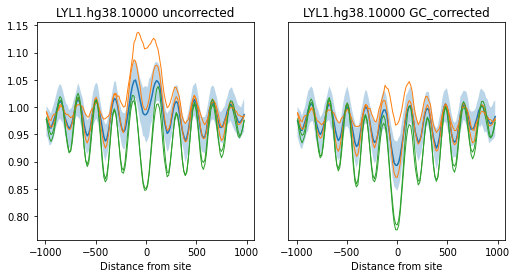

In [9]:
for site_name in site_list:
    print(site_name)
    fig,axes = plt.subplots(1,2,figsize=(9,4), sharey=True)
    for j,correction in enumerate(['uncorrected','GC_corrected']):
        current_data = ulp_data[(ulp_data['filter']==filtered) & (ulp_data['correction']==correction)]
        current_data = current_data[current_data['site_name']==site_name]
        print(len(current_data))
        axes[j].plot(plot_columns, current_data[str_plot_columns].mean(axis=0))
        axes[j].fill_between(plot_columns, np.percentile(current_data[str_plot_columns],25, axis = 0), np.percentile(current_data[str_plot_columns],75, axis = 0), alpha=0.3)
        axes[j].set_title(site_name + ' ' + correction)

        for sample in deep_samples:
            current_deep_data = deep_data[(deep_data['filter']==filtered) & (deep_data['correction']==correction)]
            current_deep_data = current_deep_data[(current_deep_data['site_name']==site_name) & (current_deep_data['sample']==sample)]
            axes[j].plot(plot_columns, current_deep_data[str_plot_columns].T, linewidth = 1, color = color_dict[sample])

        axes[j].set_xlabel('Distance from site')
        
        
    for j in range(2):
        axes[j].set_aspect(1.0/axes[j].get_data_ratio(), adjustable='box') 
    axes[1].tick_params(labelleft=False, left=False)
    fig.subplots_adjust(wspace = 0.0)
    plt.savefig('plots/'+site_name+'.cov_profiles.pdf')
    

LYL1.hg38.10000
191
191


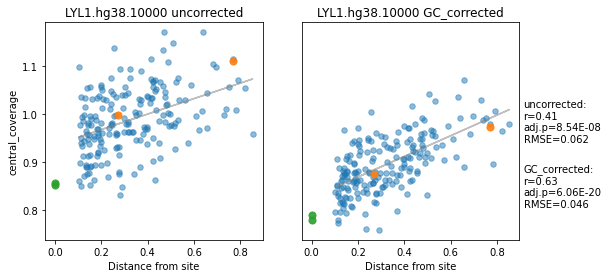

In [10]:
feature = 'central_coverage'
ulp_marker_size = 30
deep_marker_size = 50

for site_name in site_list:
    print(site_name)
    fig,axes = plt.subplots(1,2, figsize=(9.2,4), sharey=True)
    labels = []
    for j,correction in enumerate(['uncorrected','GC_corrected']):
        current_data = ulp_data[(ulp_data['filter']==filtered) & (ulp_data['correction']==correction)]
        current_data = current_data[current_data['site_name']==site_name]
        print(len(current_data))
        axes[j].scatter(current_data['tumor_fraction'], current_data[feature], color = 'tab:blue', alpha = 0.5, s = ulp_marker_size)
        axes[j].set_title(site_name + ' ' +correction)
            
        #add line of best fit
        lin_reg_slope, lin_reg_intercept, pearson_r, pearson_pval, lin_reg_std_err = linregress(current_data['tumor_fraction'], current_data[feature])
        fit_line = lin_reg_slope*current_data['tumor_fraction']+lin_reg_intercept
        RMSE = np.sqrt(mean_squared_error(current_data[feature],fit_line))
        pearson_r = str(np.round(pearson_r,2))
        #pval = '{:.2E}'.format(pearson_pval)
        pval = stat_dict[correction].loc[site_name]['pearson-adjusted-p-val_central_coverage']
        pval = '{:.2E}'.format(pval)
        RMSE_str = str(np.round(RMSE,3))
        label = correction+':\nr='+pearson_r+'\nadj.p='+pval+'\nRMSE='+RMSE_str
        labels.append(label)
        
        axes[j].plot(current_data['tumor_fraction'],fit_line, color= 'grey', alpha = 0.5)

        #add deep data
        for sample in deep_samples:
            current_deep_data = deep_data[(deep_data['filter']==filtered) & (deep_data['correction']==correction)]
            current_deep_data = current_deep_data[(current_deep_data['site_name']==site_name) & (current_deep_data['sample']==sample)]
            axes[j].scatter(current_deep_data['tumor_fraction'], current_deep_data[feature], color = color_dict[sample], alpha = 0.9, s = deep_marker_size)

        axes[j].set_xlabel('Distance from site')
   
    
    axes[0].set_ylabel(feature)
           
    for j in range(2):
        axes[j].set_aspect(1.0/axes[j].get_data_ratio(), adjustable='box') 
    axes[1].tick_params(labelleft=False, left=False)
    fig.subplots_adjust(wspace = 0.0)

    
    axes[1].text(1.02,.45,labels[0],transform=axes[1].transAxes)
    axes[1].text(1.02,.15,labels[1],transform=axes[1].transAxes)
    plt.savefig('plots/'+site_name+'.tfx_correlations.pdf')
    